Based on "A Neural Probabilistic Language Model" by Bengio et al. (2003)

In [8]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
with open('data/names.txt', 'r') as f:
    words = [word.strip().lower() + '.' for word in f.readlines()]

train, valid, test = 0.8, 0.1, 0.1
train_words = words[:int(len(words) * train)]
valid_words = words[int(len(words) * train):int(len(words) * (train + valid))]
test_words = words[int(len(words) * (train + valid)):]

print(f'Average word length in training set: {sum([len(word) for word in train_words]) / len(train_words)}')

Average word length in training set: 7.132521657691407


In [11]:
class WordDataSet(Dataset):
    def __init__(self, words, blck_size):
        self.words = words
        self.blck_size = blck_size

        # Create a dictionary that maps char to integers, and vice versa
        self.chars = sorted(list(set(''.join(self.words))))
        self.char_to_int = {c: i + 1 for i, c in enumerate(self.chars)}
        self.char_to_int['.'] = 0
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}

        X, y = [], []
        for w in self.words:
            context = [0] * blck_size
            for i in range(len(w)):
                idx = self.char_to_int[w[i]]
                X.append(context)
                y.append(idx)
                context = context[1:] + [idx]

        self.X = torch.tensor(X)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]    

In [18]:
blck_size = 4
train_ds = WordDataSet(train_words, blck_size)
valid_ds = WordDataSet(valid_words, blck_size)
test_ds = WordDataSet(test_words, blck_size)

train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=256, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=True)

In [19]:
class NNLM(torch.nn.Module):
    # Neural Network Language Model
    def __init__(self, emb_size, hidden_size, vocab_size, blck_size):
        super(NNLM, self).__init__()
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.blck_size = blck_size

        self.emb = torch.nn.Parameter(torch.randn(vocab_size, emb_size))
        self.W1 = torch.nn.Parameter(torch.randn(emb_size * blck_size, hidden_size))
        self.b1 = torch.nn.Parameter(torch.randn(hidden_size))
        self.W2 = torch.nn.Parameter(torch.randn(hidden_size, vocab_size))
        self.b2 = torch.nn.Parameter(torch.randn(vocab_size))

    def forward(self, x):
        x = self.emb[x]
        x = x.view(-1, self.emb_size * self.blck_size)
        x = torch.tanh(torch.matmul(x, self.W1) + self.b1)
        x = torch.matmul(x, self.W2) + self.b2
        return x

* Embedding size > 32 doesn't make sense, because the alphabet size is only 26.
* The block size is set to 4. It doesn't make sense to set it to be > 7, which is the average word length in the training set.

In [20]:
model = NNLM(8, 128, len(train_ds.chars) + 1, blck_size)
model.to(device)
print(f'Number of parameters: {sum([p.numel() for p in model.parameters()])}')

num_epochs = 100
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_loss, valid_loss = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss.append(running_loss / len(train_dl))

    model.eval()
    running_loss = 0
    for x, y in valid_dl:
        x, y = x.to(device), y.to(device)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        running_loss += loss.item()
    valid_loss.append(running_loss / len(valid_dl))

    print(f'Epoch: {epoch + 1}/{num_epochs} | Train loss: {train_loss[-1]:.4f} | Valid loss: {valid_loss[-1]:.4f}')

Number of parameters: 8060
Epoch: 1/100 | Train loss: 8.3782 | Valid loss: 6.2132
Epoch: 2/100 | Train loss: 4.6768 | Valid loss: 4.8554
Epoch: 3/100 | Train loss: 3.8095 | Valid loss: 4.1719
Epoch: 4/100 | Train loss: 3.3363 | Valid loss: 3.7345
Epoch: 5/100 | Train loss: 3.0273 | Valid loss: 3.4336
Epoch: 6/100 | Train loss: 2.8106 | Valid loss: 3.1901
Epoch: 7/100 | Train loss: 2.6525 | Valid loss: 3.0251
Epoch: 8/100 | Train loss: 2.5357 | Valid loss: 2.8876
Epoch: 9/100 | Train loss: 2.4501 | Valid loss: 2.7851
Epoch: 10/100 | Train loss: 2.3853 | Valid loss: 2.7067
Epoch: 11/100 | Train loss: 2.3368 | Valid loss: 2.6525
Epoch: 12/100 | Train loss: 2.2994 | Valid loss: 2.6067
Epoch: 13/100 | Train loss: 2.2708 | Valid loss: 2.5594
Epoch: 14/100 | Train loss: 2.2486 | Valid loss: 2.5324
Epoch: 15/100 | Train loss: 2.2312 | Valid loss: 2.5093
Epoch: 16/100 | Train loss: 2.2171 | Valid loss: 2.5021
Epoch: 17/100 | Train loss: 2.2055 | Valid loss: 2.4843
Epoch: 18/100 | Train loss: 2.

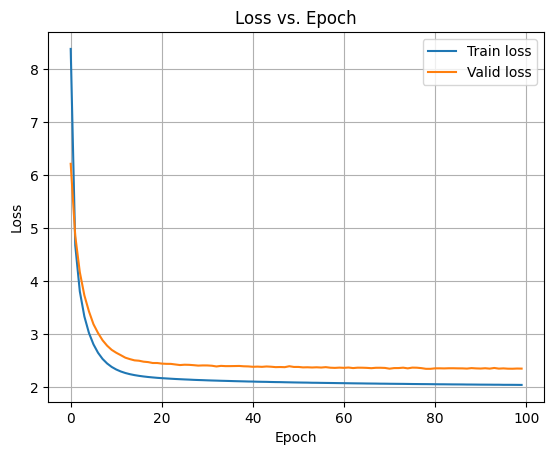

In [21]:
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.grid()
plt.show()

In [44]:
# sampling
max_length = 20
num_words = 10

model.eval()
for _ in range(num_words):
    context = [0] * blck_size
    generated_word = []
    for _ in range(max_length):
        x = torch.tensor([context])
        y_hat = model(x)
        # output has shape (1, vocab_size), squeeze to (vocab_size)
        probs = F.softmax(y_hat, dim=1).squeeze()
        sampled_char_idx = torch.multinomial(probs, 1).item()
        if sampled_char_idx == 0:
            break
        generated_word.append(train_ds.int_to_char[sampled_char_idx])
        context = context[1:] + [sampled_char_idx]
    print(''.join(generated_word))

jestea
giana
shae
ayeen
arir
ellesli
eddichannah
camir
zifi
azaez
